In [181]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial import ConvexHull
import scanpy.external as sce
import scanpy as sc
import scipy

from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
# break

# load BJ Fib data

In [3]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.h5ad"
fbdata = sc.read_h5ad(fpath)
fbdata = fbdata[fbdata.obs['dataset'] == 'chen_2015', :]

# extract most highly expressed genes
var = fbdata.var.copy()
var = var.reset_index()
var['mean_expression'] = fbdata.X.mean(axis=0)
var = var.sort_values(by='mean_expression', ascending=False)

columns = [
    'gene_name',
    'gene_biotype',
    'mean_expression',
]
var[columns].head(10)

,gene_name,gene_biotype,mean_expression
9991,MT-CO1,protein_coding,122144.444444
205,ACTB,protein_coding,100214.277778
9998,MT-ND4,protein_coding,87604.166667
9993,MT-CO3,protein_coding,83216.833333
9992,MT-CO2,protein_coding,59432.222222
10000,MT-ND5,protein_coding,50758.888889
208,ACTG1,protein_coding,47903.388889
1362,B2M,protein_coding,39259.611111
8665,LCP1,protein_coding,38850.722222
6092,GAPDH,protein_coding,36161.777778


# Load iHSC data

In [4]:
hsc_genes = [
    'PTPRC', 'ACE', 'AVP', 'CD34', 'CD44', 
    'CD53', 'CDH5', 'CDK6', 'CEBPA', 'CRHBP',
    'EMCN', 'ERG', 'FCER1G', 'FLT3', 'FOS',
    'GATA2', 'GFI1B', 'HLF', 'HOPX', 'HOXA5', 
    'IKZF1', 'ITGA3', 'JUN', 'KLF4', 'MECOM', 
    'MEIS1', 'MIXL1', 'MLLT3', 'MYCN', 'NKG7', 
    'PROCR', 'PROM1', 'PTPRC', 'RBPMS', 'REL',
    'RUNX1T1', 'SPI1', 'SPINK2', 'SPN', 'STAT5A',
    'TCF3', 'TYROBP', 'VAMP8', 'RUNX1', 'HOXA9', 
    'HLA-DRA', 'HLA-DRB1', 'HLA-DRB2', 'HLA-DRB3', 
    'HLA-DRB4', 'HLA-DRB5', 'HLA-DRB6', 'HLA-DRB7', 
    'HLA-DRB8', 'HLA-DRB9', 'HOXB4', 'NOTCH1', 'BMI1', 
    'ALDH1A1', 'KCNK17', 'IL33', 'PECAM1', 'NT5E', 'NRP2',
    'CSF3R', 'CTSB', 'CEBPD', 'MYB', 'FLI1', 'MPO', 'HBB', 
    'GATA1', 'EPOR', 'CDH1', 'KLF1', 'RXRA', 'FOXO3', 
    'MXI1', 'CTCF', 'PAX5', 'IGLL1', 'EBF1',
]

In [5]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

TOP_FIB_GENES = 200 # the number of top fibroblast genes we consider
N_HVG = 100

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
adata = adata[~adata.obs['predicted_doublet'], :] # drop predicted doublets

sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=N_HVG,
)

tf_list = adata.uns['scenic_transcription_factors']['gene_name'].values
adata.var['tf'] = adata.var['gene_name'].isin(tf_list)
adata.var['bj'] = adata.var['gene_name'].isin(var['gene_name'].head(TOP_FIB_GENES).values)
adata.var['hsc'] = adata.var['gene_name'].isin(hsc_genes)
adata

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

Text(0.5, 0, 'Sum CPM')

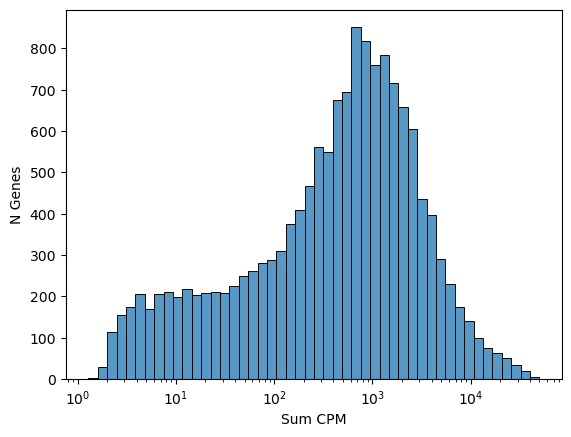

In [6]:
sns.histplot(
    adata.X.sum(axis=0), 
    log_scale=True,
)

plt.ylabel('N Genes')
plt.xlabel('Sum CPM')

# Define cluster genes

In [7]:
cell_types = {
    'EC' : 'Endothelial cells',
    'EB' : 'Erythroblasts',
    'FB' : 'Fibroblasts',
    'HSC' : 'Hematopoietic stem cells',
    'MK' : 'Megakaryocytes',
}

pang = adata.uns['panglaodb'].copy()

for k, v in cell_types.items():
    
    genes = pang[pang['cell_type'] == v]['gene_name'].values
    adata.var[k] = adata.var['gene_name'].isin(genes)
    
    exp_genes = adata.var[adata.var[k]]['gene_name']
    print(f"{v} ({k}): {len(exp_genes)} genes")
    
    score_name = f"{k}_score"
    
    sc.tl.score_genes(
        adata, 
        exp_genes, 
        score_name=score_name,
    )
    
    # make this more friendly
    adata.obs[score_name] = scipy.stats.zscore(adata.obs[score_name])

# genes from pangloa or hand curated list

adata.var['cluster_genes'] = adata.var['FB'] | adata.var['HSC'] | adata.var['bj'] | adata.var['hsc'] | adata.var['highly_variable'] #  | adata.var['tf']
adata.var['cluster_genes'].value_counts()

Endothelial cells (EC): 145 genes
Erythroblasts (EB): 24 genes
Fibroblasts (FB): 138 genes
Hematopoietic stem cells (HSC): 73 genes
Megakaryocytes (MK): 37 genes


cluster_genes
False    14570
True       495
Name: count, dtype: int64

In [8]:
# break

Performing PCA dimensionality reduction...


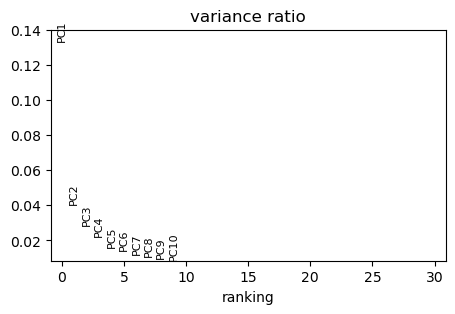

Calculating nearest neighbors...
Computing UMAP embedding...


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running Leiden clustering algorithm...


/tmp/ipykernel_1646590/3196516326.py:32: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(



Cluster distribution:
new_cluster
0    3927
1    1752
2    1708
3     602
4     447
5     127
Name: count, dtype: int64


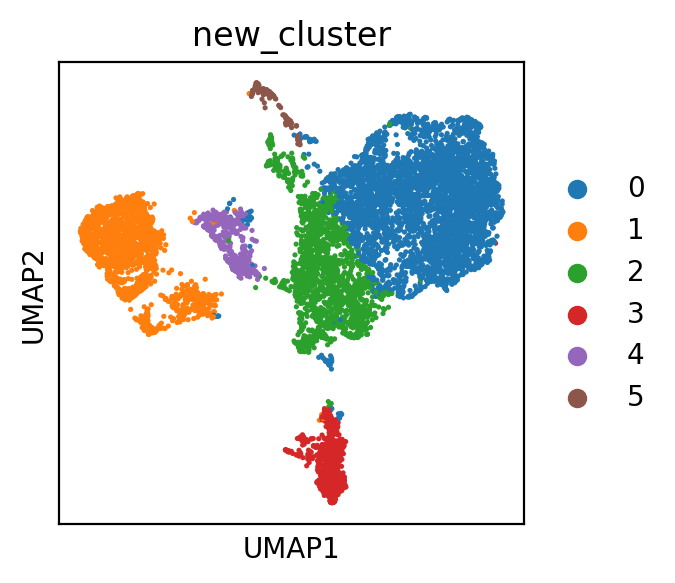

In [9]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    adata, 
    n_comps=10, 
    mask_var='cluster_genes',
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    adata, 
)

# Calculate Nearest Neighbors
print("Calculating nearest neighbors...")
sc.pp.neighbors(
    adata,
    knn=100,
)

# UMAP Embedding
print("Computing UMAP embedding...")
sc.tl.umap(
    adata,
    min_dist=0.0,
    spread=5,
)

# Leiden Clustering
print("Running Leiden clustering algorithm...")
sc.tl.leiden(
    adata, 
    resolution=0.2, 
    directed=True,
    key_added='new_cluster',
)

# Optionally, you can add a print statement to inspect the clusters:
print("\nCluster distribution:")
print(adata.obs['new_cluster'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
# Plot it!
sc.pl.umap(
    adata,
    color='new_cluster',
)

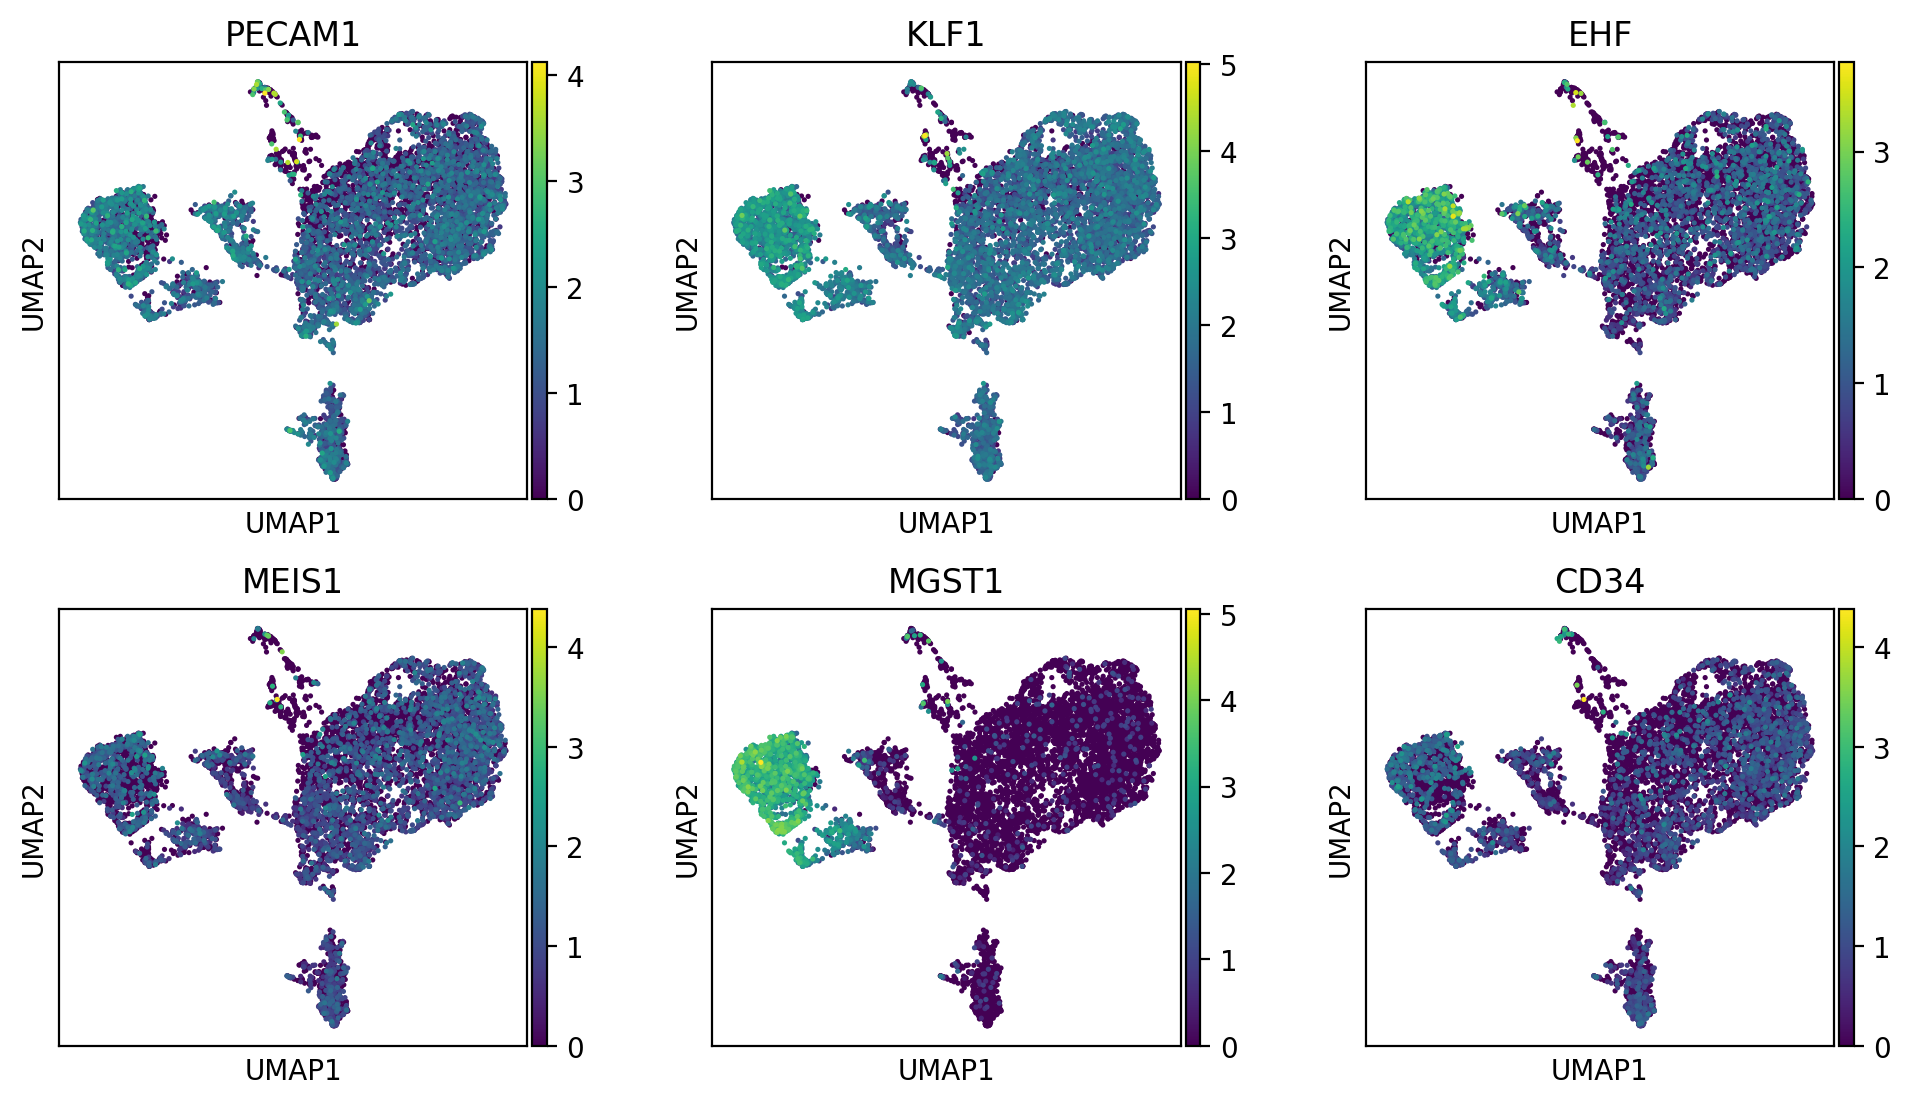

In [11]:
sc.pl.umap(
    adata,
    color=['PECAM1', 'KLF1', 'EHF', "MEIS1", 'MGST1', "CD34"],
    ncols=3,
)

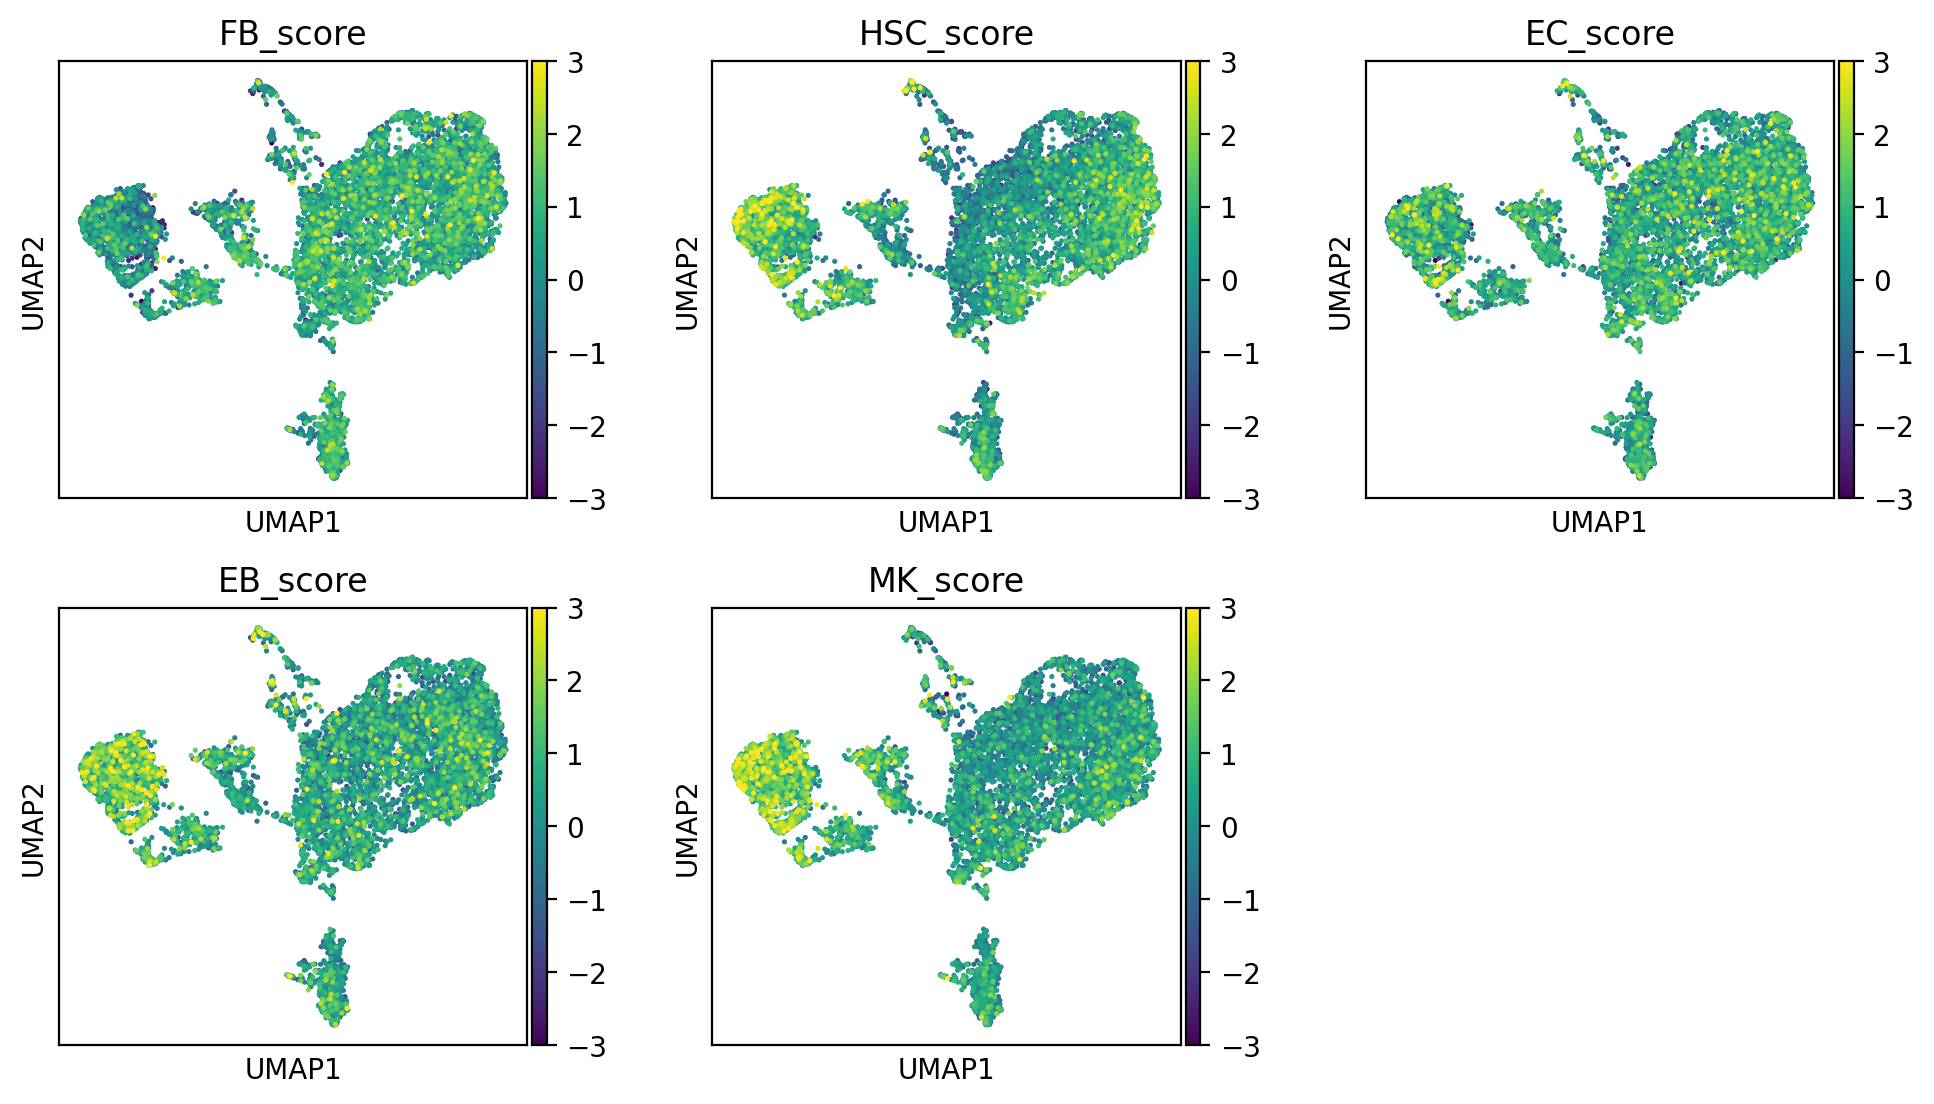

In [12]:
sc.pl.umap(
    adata,
    color=["FB_score", "HSC_score", "EC_score", 'EB_score', 'MK_score'],
    ncols=3,
    vmin=-3, 
    vmax=3,
)

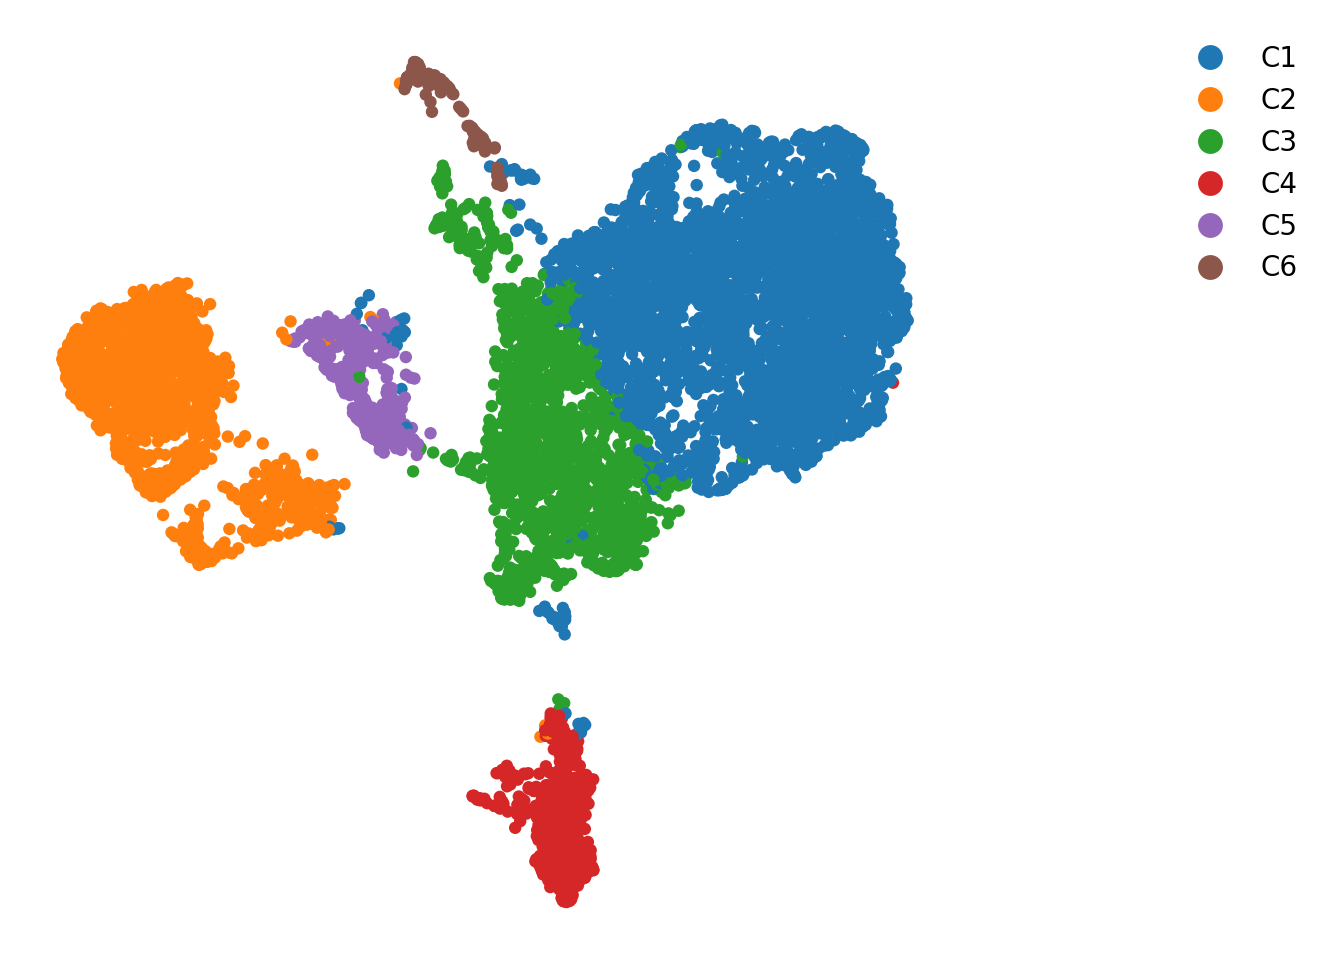

In [103]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

adata.obs['cluster_str'] = adata.obs['new_cluster'].astype(int).apply(lambda x : "C" + str(x+1))

sns.scatterplot(
    data=adata.obs,
    x=adata.obsm['X_umap'][:, 0],
    y=adata.obsm['X_umap'][:, 1],
    ec='none',
    hue_order=sorted(adata.obs['cluster_str'].unique()),
    s=20,
    hue='cluster_str',
    palette='tab10',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
# sns.despine()
plt.axis(False)

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.4, 1),
                markerscale=2,
               )

In [14]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="new_cluster",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='deg',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='deg',
)

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,0,ZNF416,59.107777,2.441200,0.0,0.0,0.999491,0.869284
1,0,IL4I1,54.698078,1.929153,0.0,0.0,1.000000,0.942623
2,0,ZFP82,53.811306,1.988346,0.0,0.0,0.998217,0.837144
3,0,UBE2S,53.667488,2.156020,0.0,0.0,0.996690,0.828516
4,0,LRG1,52.178192,2.069696,0.0,0.0,0.989305,0.707722


In [92]:
alpha = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.3
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig['hsc'] = sig['names'].isin(hsc_genes)
sig['bj'] = sig['names'].isin(adata.var[adata.var['bj']].index)

for k,v in cell_types.items():
    sig[k] = sig['names'].isin(adata.var[adata.var[k]].index)

sig['tf'] = sig['names'].isin(tf_list)

print(f"{sig.shape=}")

for cluster, group in sig.groupby('group'):
    print(f"{cluster=}")
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    print(group[['group', 'names', 'logfoldchanges', 'pct_nz_group']].head(10))

sig.shape=(5741, 16)
cluster='0'
   group    names  logfoldchanges  pct_nz_group
0      0   ZNF416        2.441200      0.999491
5      0  ZNF585A        2.206788      0.992615
3      0    UBE2S        2.156020      0.996690
4      0     LRG1        2.069696      0.989305
20     0    FSTL1        2.021330      0.997708
2      0    ZFP82        1.988346      0.998217
8      0   ZSWIM6        1.981360      0.996435
1      0    IL4I1        1.929153      1.000000
12     0   TOMM70        1.919840      0.996180
6      0   ZNF418        1.863936      0.997199
cluster='1'
      group        names  logfoldchanges  pct_nz_group
15068     1        MGST1        7.463575      0.946918
15081     1      TRMT61B        6.988453      0.756279
15075     1        SPCS3        6.976274      0.797374
15065     1  ABCF2-H2BK1        6.704796      0.983447
15066     1        CENPS        6.462372      0.993721
15067     1         ASNS        6.144143      0.989726
15192     1      ARFGEF3        6.085119  

In [215]:
def print_deg_table(sig, column_select=None, top=3):
    
    table = sig.copy()
    table['cluster'] = table['group'].astype(int) + 1
    table = table.sort_values(by=['cluster', 'pct_nz_group'], 
                              ascending=[True, False])
    
    if not column_select is None:
        table = table[table[column_select]]
        
    table = table.groupby('cluster').head(top)
        
    columns = [
        'cluster',
        'names',
        'logfoldchanges',
        'pvals_adj',
        'pct_nz_group',
    ]
    
    print(table[columns].round(3).astype(str).to_latex(index=False))
    
    
    
print_deg_table(sig, column_select='HSC')

# sig[sig['FB']].sort_values(by='pct_nz_group', ascending=False ).head(15)

\begin{tabular}{lllll}
\toprule
cluster & names & logfoldchanges & pvals_adj & pct_nz_group \\
\midrule
1 & NOTCH2 & 0.513 & 0.0 & 0.541 \\
1 & APC & 0.918 & 0.0 & 0.5 \\
1 & MEIS1 & 0.398 & 0.0 & 0.465 \\
2 & MGST1 & 7.464 & 0.0 & 0.947 \\
2 & MPL & 0.542 & 0.0 & 0.633 \\
2 & ADGRG1 & 0.314 & 0.001 & 0.44 \\
3 & BMI1 & 0.238 & 0.009 & 0.344 \\
3 & KITLG & 0.265 & 0.007 & 0.303 \\
4 & MPL & 0.487 & 0.0 & 0.752 \\
4 & NOTCH2 & 0.292 & 0.001 & 0.62 \\
4 & ADGRG1 & 0.352 & 0.0 & 0.598 \\
5 & MPL & 0.808 & 0.0 & 0.803 \\
5 & CDCP1 & 0.507 & 0.0 & 0.546 \\
5 & THY1 & 0.443 & 0.007 & 0.394 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1646590/3948420865.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdf[genes] = pdf.groupby('new_cluster')[genes].transform('mean')
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


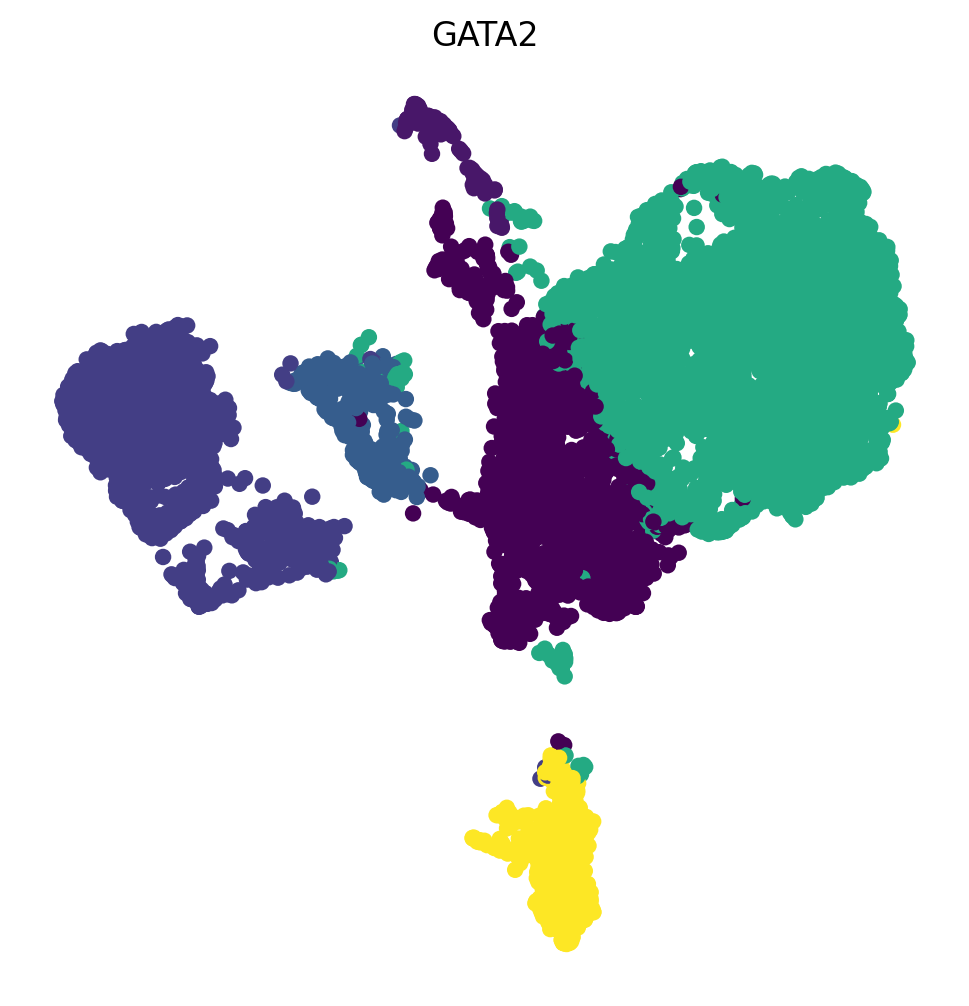

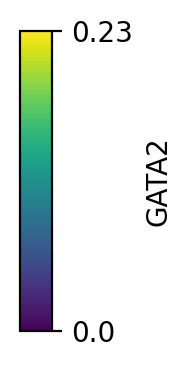

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


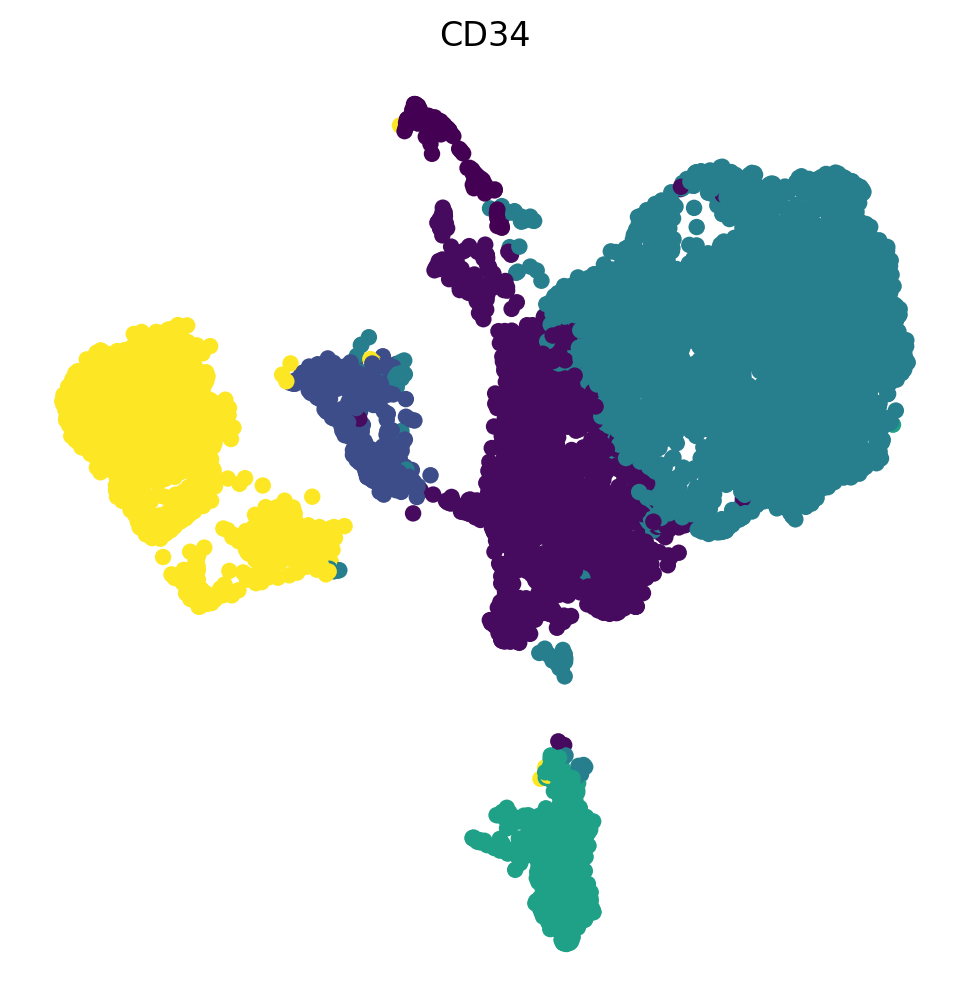

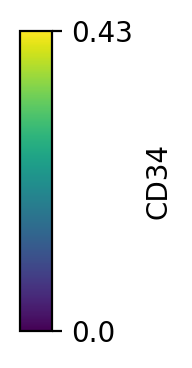

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


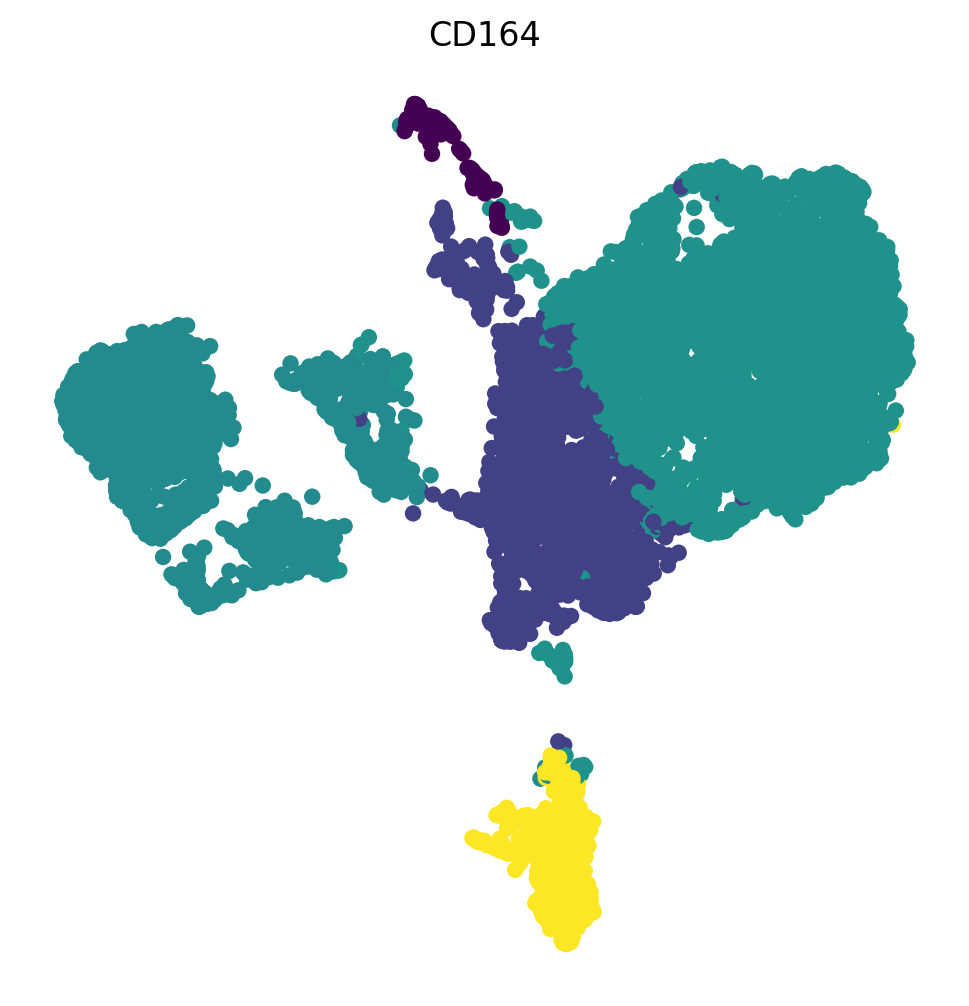

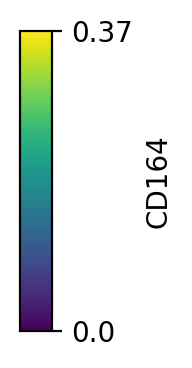

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


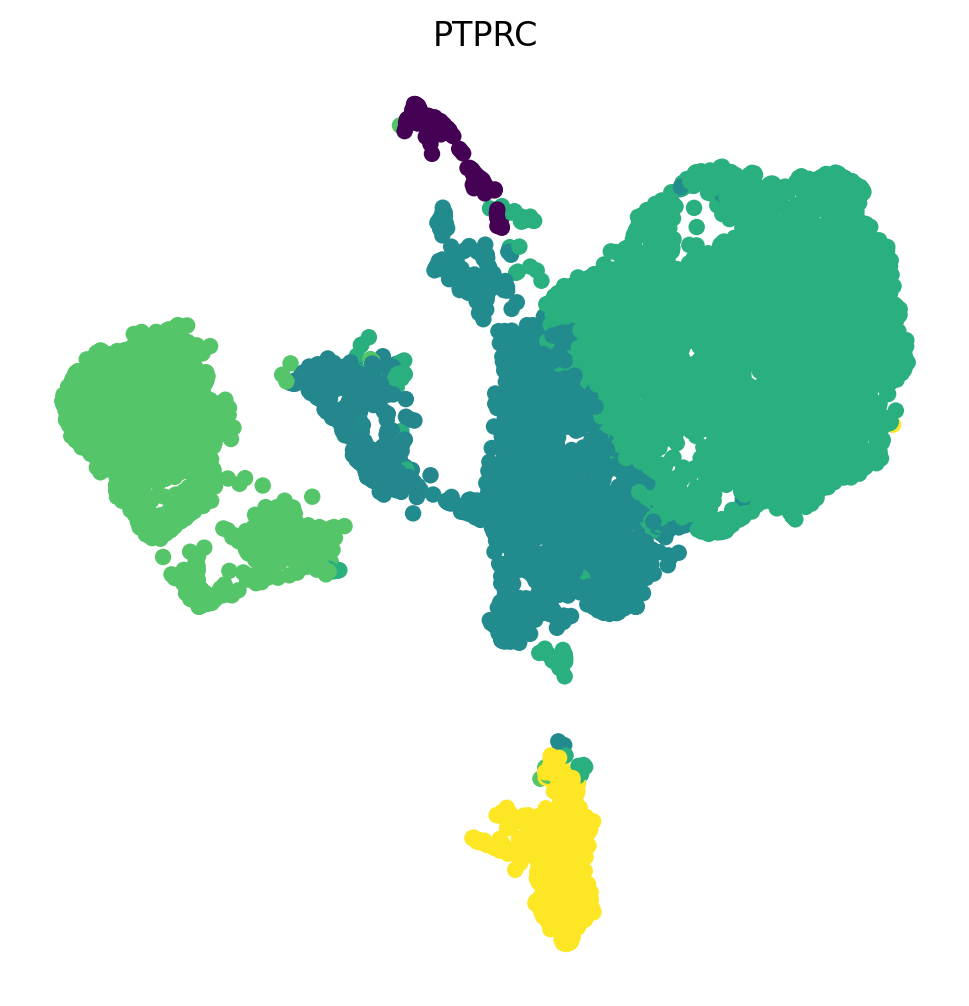

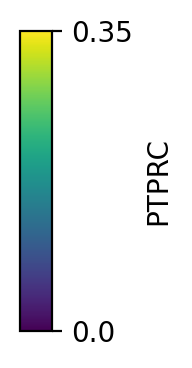

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


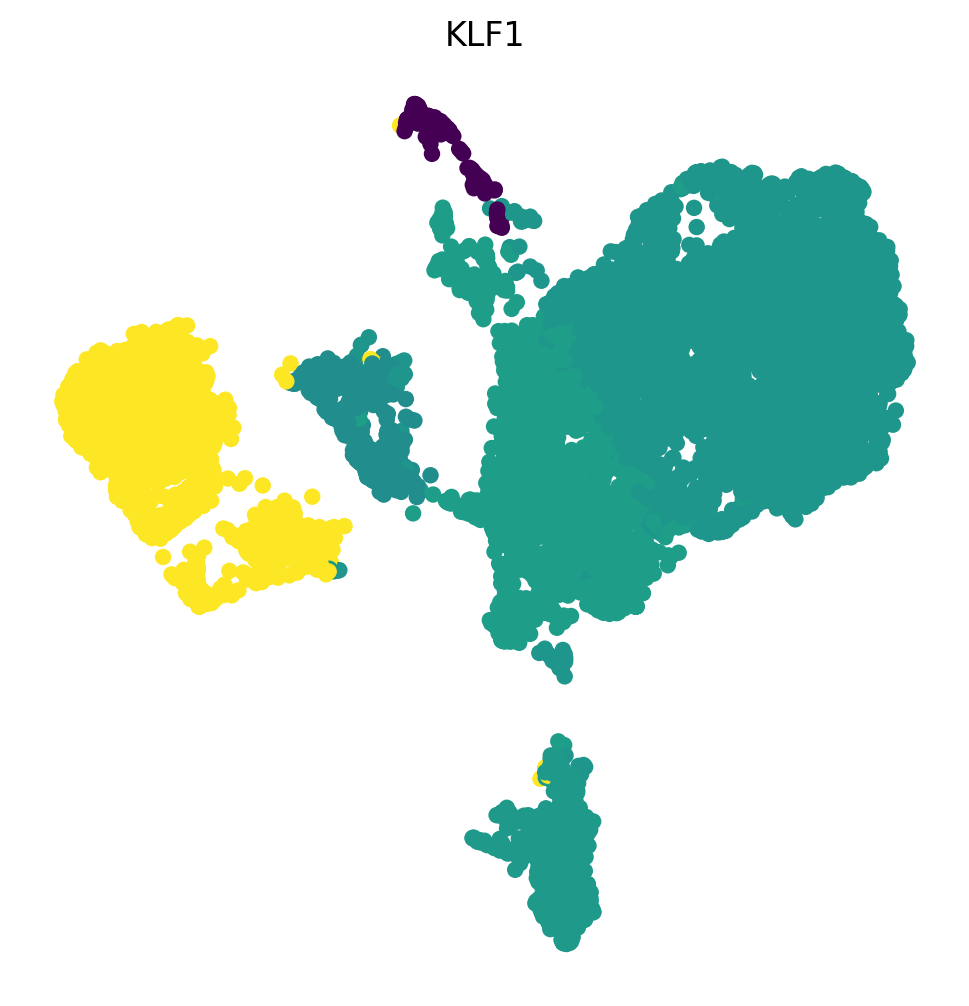

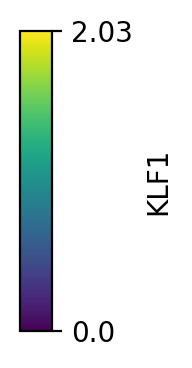

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


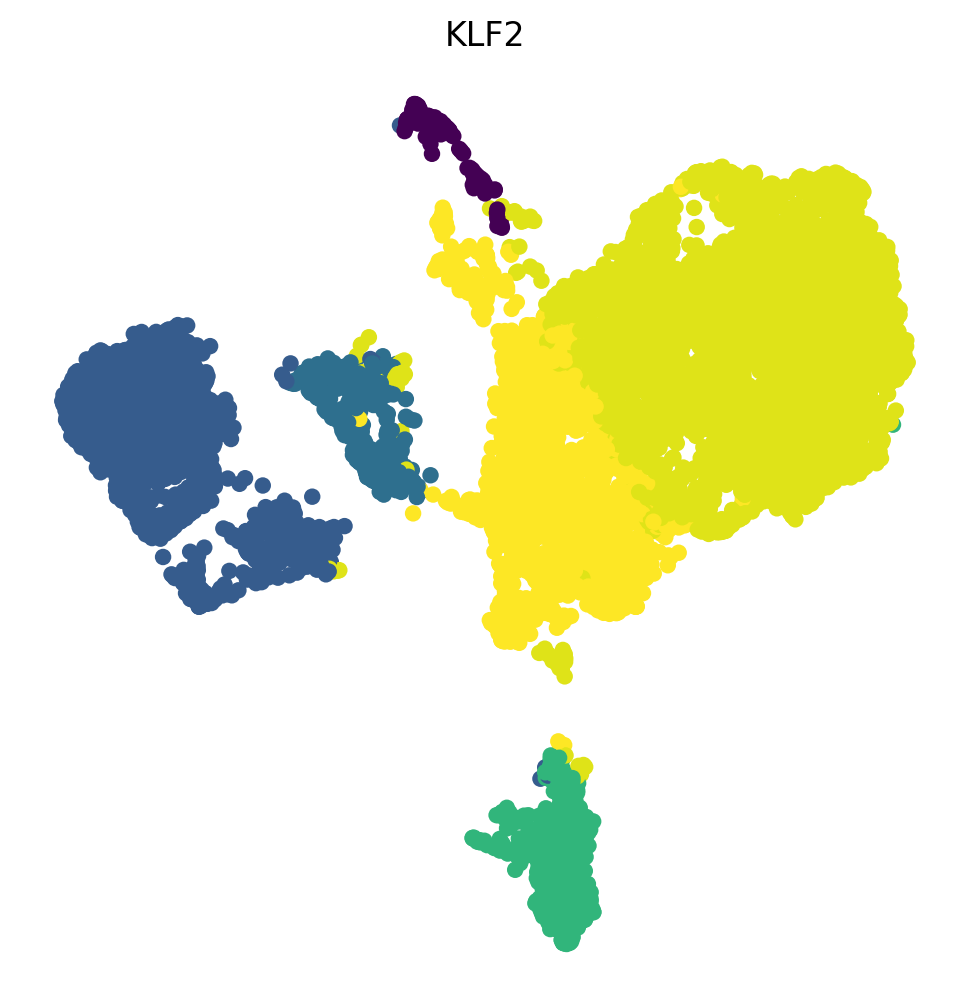

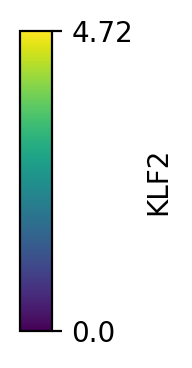

In [188]:
genes = [
    'GATA2',
    'CD34',
    'CD164',
    'PTPRC',
    'KLF1',
    'KLF2',
]

pdf = adata.obs.copy()
pdf['UMAP 1'] = adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = adata.obsm['X_umap'][:, 1]
pdf[genes] = adata[:, genes].to_df()


# grouped mean expression
pdf[genes] = pdf.groupby('new_cluster')[genes].transform('mean')


for gene in genes:

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        vmin=0,
        s=35,
        hue=gene,
        palette='viridis',
        legend=False,
    )

    plt.title(gene)
    plt.xticks([])
    plt.yticks([])

    plt.ylabel('UMAP 2')
    plt.xlabel('UMAP 1')
    plt.gca().set_aspect('auto')
    # sns.despine()
    plt.axis(False)
    plt.show()
    
    plt2.make_colorbar(title=gene, tick_labels=[f"0.0", 
                                                f"{pdf[gene].max():.2f}"])
    
    plt.show()
    
    # break


In [ ]:
break